In [8]:
import scipy
import numpy as np
from curves import ClosedSpline, NormalizeTrajectory, CompareCurves
from mechanisms.fivebar import FiveBar, GetTrajectory, Animate
from optimizer_data import store_results
from IPython.display import HTML
import os 
import h5py
from joblib import Parallel, delayed
import timeit
from matplotlib import pyplot as plt

dataset_path='fivebar_dataset.h5'

In [ ]:
## Generate a dataset of trajectories for multiple 4bar linkages
lengths_sweep=np.linspace(0.05,0.80,8)
xx=np.meshgrid(lengths_sweep,lengths_sweep,lengths_sweep,lengths_sweep,lengths_sweep)
xx_flat = np.array([x.flatten() for x in xx]).transpose()

def process_point(xi):
    start_time = timeit.default_timer()
    fbar = FiveBar(1,*xi)
    fbar.setTheta40(np.deg2rad(80))
    fbar.setGR(1)
    traj, thetas = GetTrajectory(fbar)
    elapsed = timeit.default_timer() - start_time
    return traj, thetas,elapsed

start_time = timeit.default_timer()
results = Parallel(n_jobs=32)(delayed(process_point)(xx_flat[i,:]) for i in range(xx_flat.shape[0]))
trajectories, fks, exectimes = zip(*results)
elapsed = timeit.default_timer() - start_time

store_results(dataset_path, xx_flat, np.array(trajectories), np.array(fks))
print('Exectime:{:1.2f}s',elapsed)

Added results.
Exectime: 331.9198122000089


dode


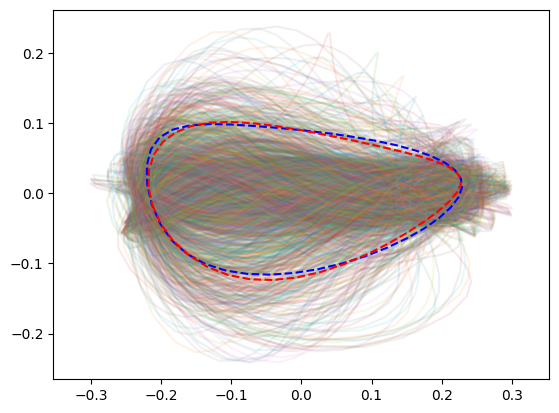

In [9]:
# Load the dataset and find the best trajectory
points = [[0,0], [3,0], [1,1], [0,1],[0,0]]
trajectory_star = ClosedSpline(points, n=40)
trajectory_star=np.stack([trajectory_star.xx,trajectory_star.yy],axis=1)
traj_star,_,_,_=NormalizeTrajectory(trajectory_star)

with h5py.File(dataset_path, "r") as f:
    params_ds = f["params"]
    traj_ds = f["trajectories"]
    fk_ds = f["fks"]
    er_ds = 1000*np.ones(params_ds.shape[0])    
    for i in range(0,params_ds.shape[0]):
        traj=traj_ds[i,:,:]                
        if np.isnan(traj).any():
            continue
        if np.square(traj[0,:]-traj[-1,:]).sum()>1e-3:
            continue
        traj,_,_,_=NormalizeTrajectory(traj)
        er=CompareCurves(traj_star[:,0],traj_star[:,1],traj[:,0],traj[:,1])
        
        er_ds[i]=er
        plt.plot(traj[:,0],traj[:,1],alpha=0.1)
    plt.axis('equal')

    idx=er_ds.argmin()
    params_best=params_ds[idx,:]
    trajectory_best=traj_ds[idx,:]


plt.plot(traj_star[:,0],traj_star[:,1],'b--')
traj_best,_,_,_=NormalizeTrajectory(trajectory_best)
plt.plot(traj_best[:,0],traj_best[:,1],'r--')
plt.axis('equal')
print('dode')


[0.15511699 0.58683357 0.80115168 0.05065063 0.79912993]


(np.float64(-0.2427837940079916),
 np.float64(0.2515547427985899),
 np.float64(-0.13489285930991174),
 np.float64(0.1130466990172863))

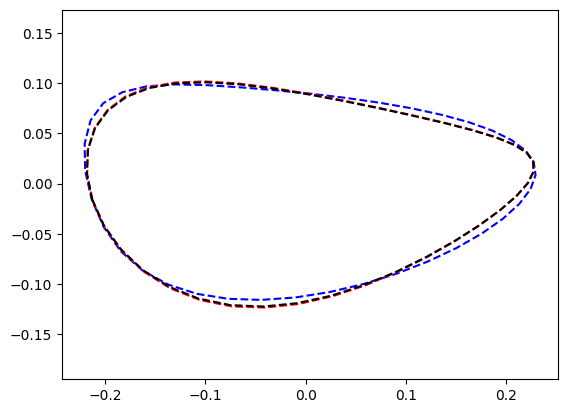

In [10]:
traj_star,center_star,scale_star,rotm_star=NormalizeTrajectory(trajectory_star)

def opt_fun(x):    
    fivebar=FiveBar(1,*x)             
    fivebar.setTheta40(np.deg2rad(80))
    fivebar.setGR(1)    
    trajectory,_=GetTrajectory(fivebar)  
    if np.isnan(trajectory).any():
        er=1000        
    else:
        traj,_,_,_=NormalizeTrajectory(trajectory)
        er=CompareCurves(traj_star[:,0],traj_star[:,1],traj[:,0],traj[:,1])    
    return er

x0=params_best
out_opt=scipy.optimize.least_squares(opt_fun,x0,bounds=([0.01,0.01,0.01,0.01,0.01],[2,2,2,2,2]),method='dogbox',ftol=1e-5,xtol=1e-4,gtol=1e-4)
print(out_opt.x)

plt.plot(traj_star[:,0],traj_star[:,1],'b--')
plt.plot(traj_best[:,0],traj_best[:,1],'r--')
fivebar=FiveBar(1,*out_opt.x[0:5]) 
fivebar.setTheta40(np.deg2rad(80))
fivebar.setGR(1)           
trajectory,_=GetTrajectory(fivebar)
traj_best,center_best,scale_best,rotm_best=NormalizeTrajectory(trajectory)
plt.plot(traj_best[:,0],traj_best[:,1],'k--')
plt.axis('equal')

In [11]:
# De-normalize the trajectory
tt=trajectory*scale_star/scale_best
if np.linalg.det(rotm_best)<0:    
    rotm=np.matmul(rotm_best,rotm_star)
else:
    rotm=np.matmul(rotm_best,rotm_star.T)
tt2=np.matmul(rotm,tt.T).T+center_star-np.matmul(rotm,center_best*scale_star/scale_best)

fivebar=FiveBar(scale_star/scale_best*1,*(scale_star/scale_best*out_opt.x))
fivebar.setTheta40(np.deg2rad(80))
fivebar.setGR(1) 
offset=center_star-np.matmul(rotm,center_best*scale_star/scale_best)
fivebar.setRotm(rotm)
fivebar.setOloc(*offset)
ani,fig=Animate(fivebar,trajectory_star)

plt.close(fig)
HTML(ani.to_jshtml())